## AdaBoost Modeling and some EDA using: 
### - Transformer: CountVectorizer
### - Lemmatized words

In [1]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Naive Bayes 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# Logistic Regression 
from sklearn.linear_model import LogisticRegression

# Boosting 
from sklearn.ensemble import AdaBoostClassifier

# Other Sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# NLP imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# nltk.download()  --> Download all, and then restart jupyter lab
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

### Loading Data and Splitting Data

In [2]:
# Load the data
df = pd.read_csv('../../../data/clean_data/clean_posts.csv', index_col=0)
df.head()

,subreddit,title,created_utc,selftext,title_selftext,author,media_only,permalink,text_length,clean_text_stem,clean_text_lem
0,tolkienfans,What happened to Tolkien’s Red Book?,1616977706,I was wondering if somebody could clear up my ...,what happened to tolkien s red book i was wond...,lukeskinwalker69epic,False,/r/tolkienfans/comments/mfdrms/what_happened_t...,322,happen tolkien red book wonder somebodi could ...,happened tolkien red book wondering somebody c...
1,tolkienfans,What Makes People Turn Invisible When the Put ...,1616971688,I guess this is a big question because I never...,what makes people turn invisible when the put ...,Jpmaniax26,False,/r/tolkienfans/comments/mfbzjh/what_makes_peop...,252,make peopl turn invis put one ring guess big q...,make people turn invisible put one ring guess ...
2,tolkienfans,"Theory: At some point not told in the Tale, Ar...",1616971077,This is the last dialogue between Queen Undómi...,theory at some point not told in the tale arag...,yew_eater,False,/r/tolkienfans/comments/mfbsks/theory_at_some_...,6045,theori point told tale aragorn arwen must seri...,theory point told tale aragorn arwen must seri...
3,tolkienfans,I’d like to purchase a matching set of books o...,1616969977,Can anyone help me out? Looking for matching b...,i d like to purchase a matching set of books o...,GoosePants72,False,/r/tolkienfans/comments/mfbfyj/id_like_to_purc...,302,like purchas match set book everyth lotr silma...,like purchase matching set book everything lot...
4,tolkienfans,"When Faramir ‘proposes’ to Eowyn, something we...",1616966528,After he confesses his love for her and talks ...,when faramir proposes to eowyn something weird...,PhendranaDrifter,False,/r/tolkienfans/comments/mfaae8/when_faramir_pr...,731,faramir propos eowyn someth weird happen confe...,faramir proposes eowyn something weird happens...


In [3]:
# Checks baseline
df['subreddit'].value_counts(normalize=True)
# df['subreddit'].value_counts()

tolkienfans    0.516823
harrypotter    0.483177
Name: subreddit, dtype: float64

In [5]:
# Set up X and y
X = df['clean_text_lem']
y = df['subreddit']

In [6]:
# Splits the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    random_state=42)

### Modeling

In [8]:
# Baseline accuracy 
y_test.value_counts(normalize=True)

tolkienfans    0.516821
harrypotter    0.483179
Name: subreddit, dtype: float64

In [9]:
# Instantiates a pipeline 
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('abc', AdaBoostClassifier())
])

In [10]:
# Creates the pipe parameters 
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df':[1, 2],
    'cvec__max_df':[0.90, 0.98],
    'cvec__ngram_range':[(1,1), (1,2)],
    'abc__n_estimators': [50, 100]
}

In [11]:
# Instantiates the GridSearchCV
gs = GridSearchCV(pipe, 
                param_grid=pipe_params,
                cv=5, 
                verbose=1,
                 n_jobs=4)

In [12]:
# Fits GridSearch to training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed: 10.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('abc', AdaBoostClassifier())]),
             n_jobs=4,
             param_grid={'abc__n_estimators': [50, 100],
                         'cvec__max_df': [0.9, 0.98],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [13]:
# Returns the CV accuracy score from the gridsearch
gs.best_score_

0.9490395411117669

In [14]:
# Returns the training and testing accuracy score from the gridsearch
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9550679938314874, 0.951009251471825)

In [15]:
# Returns the best parameters from the gridsearch
gs.best_params_

{'abc__n_estimators': 100,
 'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

#### Second Iteration

In [24]:
# Instantiates a pipeline 
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('abc', AdaBoostClassifier())
])

In [25]:
# Instantiates the pipe parameters to be passed into the gridsearch
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df':[1, 2],
    'cvec__max_df':[0.90, 0.98],
    'cvec__ngram_range':[(1,1), (1,2)],
    'abc__n_estimators': [100, 150, 200, 250]
}

In [26]:
# Instantiates the GridSearchCV
gs = GridSearchCV(pipe, 
                param_grid=pipe_params,
                cv=5, 
                verbose=1, 
                 n_jobs=4)

In [27]:
# Fits GridSearch to training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 21.9min
[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed: 35.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('abc', AdaBoostClassifier())]),
             n_jobs=4,
             param_grid={'abc__n_estimators': [100, 150, 200, 250],
                         'cvec__max_df': [0.9, 0.98],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [28]:
# returns the training and testing accuracy scores from the gridsearch
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9754661432777233, 0.9611017661900757)

In [29]:
# Returns the best parameters from the gridsearch
gs.best_params_

{'abc__n_estimators': 250,
 'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

## Re-Run the AdaBoost Model with the Second Iteration Best Params

In [30]:
# Load the data
df = pd.read_csv('../../../data/clean_data/clean_posts.csv', index_col=0)
df.head()

,subreddit,title,created_utc,selftext,title_selftext,author,media_only,permalink,text_length,clean_text_stem,clean_text_lem
0,tolkienfans,What happened to Tolkien’s Red Book?,1616977706,I was wondering if somebody could clear up my ...,what happened to tolkien s red book i was wond...,lukeskinwalker69epic,False,/r/tolkienfans/comments/mfdrms/what_happened_t...,322,happen tolkien red book wonder somebodi could ...,happened tolkien red book wondering somebody c...
1,tolkienfans,What Makes People Turn Invisible When the Put ...,1616971688,I guess this is a big question because I never...,what makes people turn invisible when the put ...,Jpmaniax26,False,/r/tolkienfans/comments/mfbzjh/what_makes_peop...,252,make peopl turn invis put one ring guess big q...,make people turn invisible put one ring guess ...
2,tolkienfans,"Theory: At some point not told in the Tale, Ar...",1616971077,This is the last dialogue between Queen Undómi...,theory at some point not told in the tale arag...,yew_eater,False,/r/tolkienfans/comments/mfbsks/theory_at_some_...,6045,theori point told tale aragorn arwen must seri...,theory point told tale aragorn arwen must seri...
3,tolkienfans,I’d like to purchase a matching set of books o...,1616969977,Can anyone help me out? Looking for matching b...,i d like to purchase a matching set of books o...,GoosePants72,False,/r/tolkienfans/comments/mfbfyj/id_like_to_purc...,302,like purchas match set book everyth lotr silma...,like purchase matching set book everything lot...
4,tolkienfans,"When Faramir ‘proposes’ to Eowyn, something we...",1616966528,After he confesses his love for her and talks ...,when faramir proposes to eowyn something weird...,PhendranaDrifter,False,/r/tolkienfans/comments/mfaae8/when_faramir_pr...,731,faramir propos eowyn someth weird happen confe...,faramir proposes eowyn something weird happens...


In [31]:
# Checks baseline
df['subreddit'].value_counts(normalize=True)
# df['subreddit'].value_counts()

tolkienfans    0.516823
harrypotter    0.483177
Name: subreddit, dtype: float64

In [33]:
df_sample = df.sample(100, random_state=42)

In [34]:
# Set up X and y
# X = df_sample['clean_text_stem']
# y = df_sample['subreddit']

X = df['clean_text_lem']
y = df['subreddit']

In [35]:
# Splits the data into training and test sets from sample
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    random_state=42)

In [36]:
# Instantiates a pipeline 
pipe = Pipeline([
    ('cvec', CountVectorizer(max_df=0.9, max_features=5000, min_df=1, ngram_range=(1,2))),
    ('abc', AdaBoostClassifier(n_estimators=250))
])

In [37]:
# best estimators:
# {'abc__n_estimators': 250,
#  'cvec__max_df': 0.9,
#  'cvec__max_features': 5000,
#  'cvec__min_df': 1,
#  'cvec__ngram_range': (1, 2)}

In [38]:
# Fits the data to the pipeline including the Countvectorizer and the AdaBoost Classifier
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000,
                                 ngram_range=(1, 2))),
                ('abc', AdaBoostClassifier(n_estimators=250))])

In [39]:
# Returns the training and testing accuracy scores from the pipeline
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9754661432777233, 0.9611017661900757)

#### Evaluation

In [40]:
# Assigns the training and testing accuracy scores to variables names to make it callable
train1, test1 = pipe.score(X_train, y_train), pipe.score(X_test, y_test)
train1, test1

(0.9754661432777233, 0.9611017661900757)

In [41]:
# Calculates the y predictions and the AUC score
y_preds = pipe.predict(X_test)
auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])

In [59]:
# Creates the model metric row dataframe to be added to the final model metric dataframe in the presentation
results = pd.DataFrame({'Model': ['AdaBoost'], 
                        'Transformer': ['CountVect'],
                        'Stemmed/Lemmed': ['Lemmatized'],
                        'Train_acc': [train1],
                        'Test_acc': [test1], 
                        'AUC': [auc]})
results.to_csv('../../../data/result_scores/boost_countvect_lem.csv')

In [55]:
results

,Model,Transformer,Stemmed/Lemmed,Train_acc,Test_acc,AUC
0,AdaBoost,CountVect,Lemmatized,0.975466,0.961102,0.993525


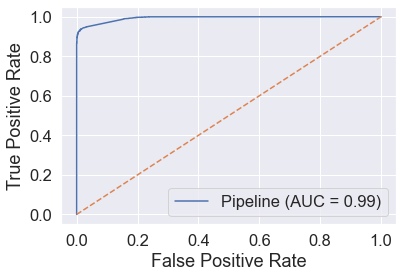

In [56]:
# Plots the ROC curve and visualizes the AUC score
plot_roc_curve(pipe, X_test, y_test)
plt.plot([0,1],[0,1], label='baseline', linestyle='--');

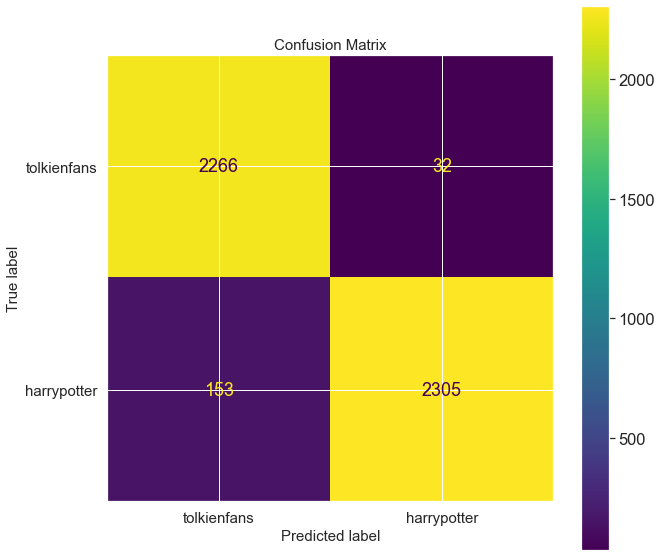

In [68]:
# Creates the confusion matrix and saves it as an image
sns.set(font_scale=1.5)
cm = confusion_matrix(y_test, y_preds)
fig, ax = plt.subplots(figsize=(10, 10))
plot = ConfusionMatrixDisplay(cm).plot(ax=ax)
plot
plt.title('Confusion Matrix')
ax.set_title('Confusion Matrix', fontdict={'size':'15'})
ax.set_xticklabels(df['subreddit'].unique(), size=15);
ax.set_yticklabels(df['subreddit'].unique(), size=15);
ax.set_xlabel('Predicted label', fontdict={'size':'15'})
ax.set_ylabel('True label', fontdict={'size':'15'})

plt.savefig('../../../presentation/imgs/cm_boost_countvect_lem.jpg')

In [62]:
dir(pipe.named_steps['abc'])

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_boost',
 '_boost_discrete',
 '_boost_real',
 '_check_X',
 '_check_n_features',
 '_compute_proba_from_decision',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_validate_data',
 '_validate_estimator',
 'algorithm',
 'base_estimator',
 'base_estimator_',
 'classes_',
 'decision_function',
 'estimator_errors_',
 'estimator_params',
 'estimator_weights_',
 'estimator

In [63]:
# Finds the feature importances from the pipeline through the AdaBoost classifier
importances = pipe.named_steps['abc'].feature_importances_

In [64]:
importances

array([0., 0., 0., ..., 0., 0., 0.])

In [65]:
# Finds the feature names from the pipeline through the tfidfVectorizer
names = pipe.named_steps['cvec'].get_feature_names()

In [66]:
# Creates the feature importance dictionary and returns a dataframe of the top 10 features 
importance_dict = pd.DataFrame({'feature_importance': importances,
                                'features': names})
top10 = importance_dict.nlargest(10, columns=['feature_importance'])
top10

,feature_importance,features
2627,0.016,lotr
4447,0.016,tolkien
3973,0.012,silmarillion
143,0.008,age
1252,0.008,dumbledore
1337,0.008,elf
1347,0.008,else
1551,0.008,fall
1804,0.008,gandalf
2008,0.008,harry


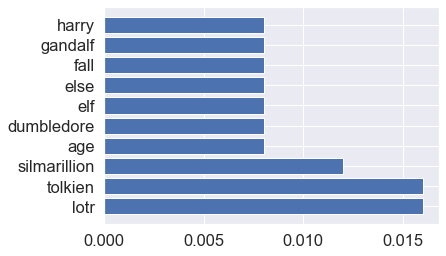

In [67]:
# Visualizes the feature importances

# plt.bar(x='features', height='feature_importances', data=top10);
plt.barh(top10['features'], top10['feature_importance']);